#### 1) Reproduce the PRISM precipitation anomaly maps for each WT 
 - 1.1) Compute precipitation climatology
 - 1.2) Precipitation anmomalies of WTs
 - 1.3) Summer/Winter WT plot (12,9,2,5) for Erin
#### 2) Precipitation Seasonal anomaly
 

In [1]:
import sys
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# inorder to import my pathon module, add
# $PYTHONPATH for jupyter for module
sys.path.append("/glade/u/home/mingge/PYTHON")
import coexist_func 
from importlib import reload
reload(coexist_func)

from coexist_func import cal_season_cli_prism
from coexist_func import ax_coastlines_country
from coexist_func import cal_season_ano_prism
from coexist_func import plot_prec_12

In [2]:
def plot_prec_12_prism(prec, min_v, max_v, n_lev, cmap_s, nwt_1d, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    fig = plt.figure(figsize=(18,14))
     
    cnlevel = np.linspace(min_v, max_v, num=n_lev)

    for col in range(12):
        ax_s = plt.subplot(4, 3, col+1, projection=ccrs.PlateCarree())
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')

        mem = col + 1

        im = prec[col].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,extend='both',
                # NOTE: transform use original data center 
                transform=ccrs.PlateCarree(),
                add_colorbar=False)
        
        ax_s.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        plt.title('WT' + str(mem) + ' (' + str(f'{nwt_1d[col]:.1f}') + '%)',fontweight="bold", size=15)
        
    # single title for All the Subplot
    fig.suptitle(' ' + title_s, fontweight="bold", fontsize=30)

    fig.tight_layout()

    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)
    #rect [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.02])

    fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# end of plot_prec_12_prism


weather types are from <br>
/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT  <br>
Produced by: AssignToExistingWTs_ERA_INTERIM.ipynb

In [3]:
# centroid_ana.ibynb, wt_hist_smyle_era5.ipynb
sCentroids='/glade/u/home/mingge/WTing_existing-centroids/CONUS-WTs_existing_centroids.npz'
DATA=np.load(sCentroids)
rgrCentroids=DATA['rgrCentroids']               # (12, 3, 24, 74)
rgiWTs=range(1, rgrCentroids.shape[0]+1, 1)     # number of WT 

lat_s = DATA['rgrLatWT'].min() - 6
lat_e = DATA['rgrLatWT'].max() + 2
lon_s = DATA['rgrLonWT'].min()  
lon_e = DATA['rgrLonWT'].max() + 6
print('lat:', lat_s , '-', lat_e, 'lon:', lon_s, '-', lon_e)

season_dict = {
    'DJF': [12,1,2],
    'MAM': [3,4,5],
    'JJA': [6,7,8],
    'SON': [9,10,11],
    'JAS': [7,8,9]}

n_season = len(season_dict)
n_season = 4

year_s = 1981
year_e = 2014
n_year = year_e - year_s + 1

n_wt = 12


lat: 24.75 - 50.0 lon: -125.25 - -64.5


In [4]:
dir_prism = '/glade/campaign/mmm/c3we/prein/observations/PRISM/data/PR/'
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/'
 
dir_wt = '/glade/campaign/mmm/c3we/mingge/ERA_INTERIM/WT/'

#### 1.1) calculate prec climatology

In [5]:
flnm_nc = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_1979-2014.nc'

if os.path.isfile(flnm_nc):
    print(flnm_nc, 'exist')
    with  xr.open_dataset(flnm_nc) as ds_prec:
        prec_mean = ds_prec.PR
        
else:  
    is_first = True
    for year in range(year_s, year_e+1, 1):
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
        print(flnm)
        with  xr.open_dataset(flnm) as ds:
            prec = ds.PR.sel(rlat=slice(lat_e, lat_s),rlon=slice(lon_s, lon_e)).mean(dim='time')
            #print(prec)
                
            if is_first == True:
                data_all = prec.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec], dim='time')
                           
    print(data_all.shape)
    prec_mean = data_all.mean(dim='time')
    prec_mean.to_netcdf( path = flnm_nc)    

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_clim_1979-2014.nc exist


/glade/work/mingge/miniconda3/envs/casper_2020/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
module 'cfgrib.messages' has no attribute 'DEFAULT_INDEXPATH'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
lat = prec_mean.rlat
lon = prec_mean.rlon
n_lat = prec_mean.shape[0]
n_lon = prec_mean.shape[1]

#### 1.2) precipitation anomalies of WTs

In [7]:
prec_3d = np.zeros((n_wt, n_lat, n_lon))

flnm_prec = '/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_wt.nc'
if os.path.isfile(flnm_prec):
    print(flnm_prec, 'exist')
    with  xr.open_dataset(flnm_prec) as ds:
        prec_xr = ds.__xarray_dataarray_variable__
else:
  for nw in range(n_wt):
    is_first = True
    for year in range(year_s, year_e+1, 1):
        StartDay = datetime.datetime(year,  1, 1,  0)
        EndDay   = datetime.datetime(year, 12, 31,  0)
        TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
        # read WT file
        flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) +'.cla'
        print(flnm_wt)
            
        wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
        wts_g = wts.groupby(['wt']) 
        g_ind = wts_g.get_group(nw+1).index
            
        # read PRISM file
        flnm = dir_prism + 'PRISM_daily_ppt_' + str(year) + '.nc'
        print(flnm)
            
        with  xr.open_dataset(flnm) as ds:
            prec = ds.PR.sel(rlat=slice(lat_e, lat_s),rlon=slice(lon_s, lon_e))
            prec_wt = prec[g_ind,:,:]
            # check time coordinates associated with WT
            #print(prec_wt)
                
            if is_first == True:
                data_all = prec_wt.copy()
                is_first = False
            else:
                data_all = xr.concat([data_all, prec_wt.copy()], dim='time')
                #print(data_all.shape)
    print(data_all.shape)                
    prec_3d[nw] = data_all.mean("time") 
        
  prec_xr = xr.DataArray(prec_3d, 
                       coords={'lat':prec_mean.rlat, 'lon': prec_mean.rlon, 'wt':range(n_wt)},
                       dims=["wt", "rlat", "rlon"])
 
  prec_xr.to_netcdf(path = flnm_prec)             
  print(flnm_prec)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_wt.nc exist


 - calculate the frequency (%) of days in each WT

In [8]:
nwt_1d = np.zeros(n_wt)
for nw in range(n_wt):
    for year in range(year_s, year_e+1, 1):       
        # read WT file
        flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) +'.cla'
        #print(flnm_wt)
            
        wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
        wts_g = wts.groupby(['wt']) 
        nwt_1d[nw] = nwt_1d[nw] + len(wts_g.get_group(nw+1)) #.index
        
print((nwt_1d))
np.set_printoptions(precision=1)
nwt_1d = nwt_1d/nwt_1d.sum()*100
print(nwt_1d)

[1127. 1248.  765. 1272. 1323.  913.  685.  820. 1281.  797.  750. 1437.]
[ 9.1 10.   6.2 10.2 10.7  7.4  5.5  6.6 10.3  6.4  6.  11.6]


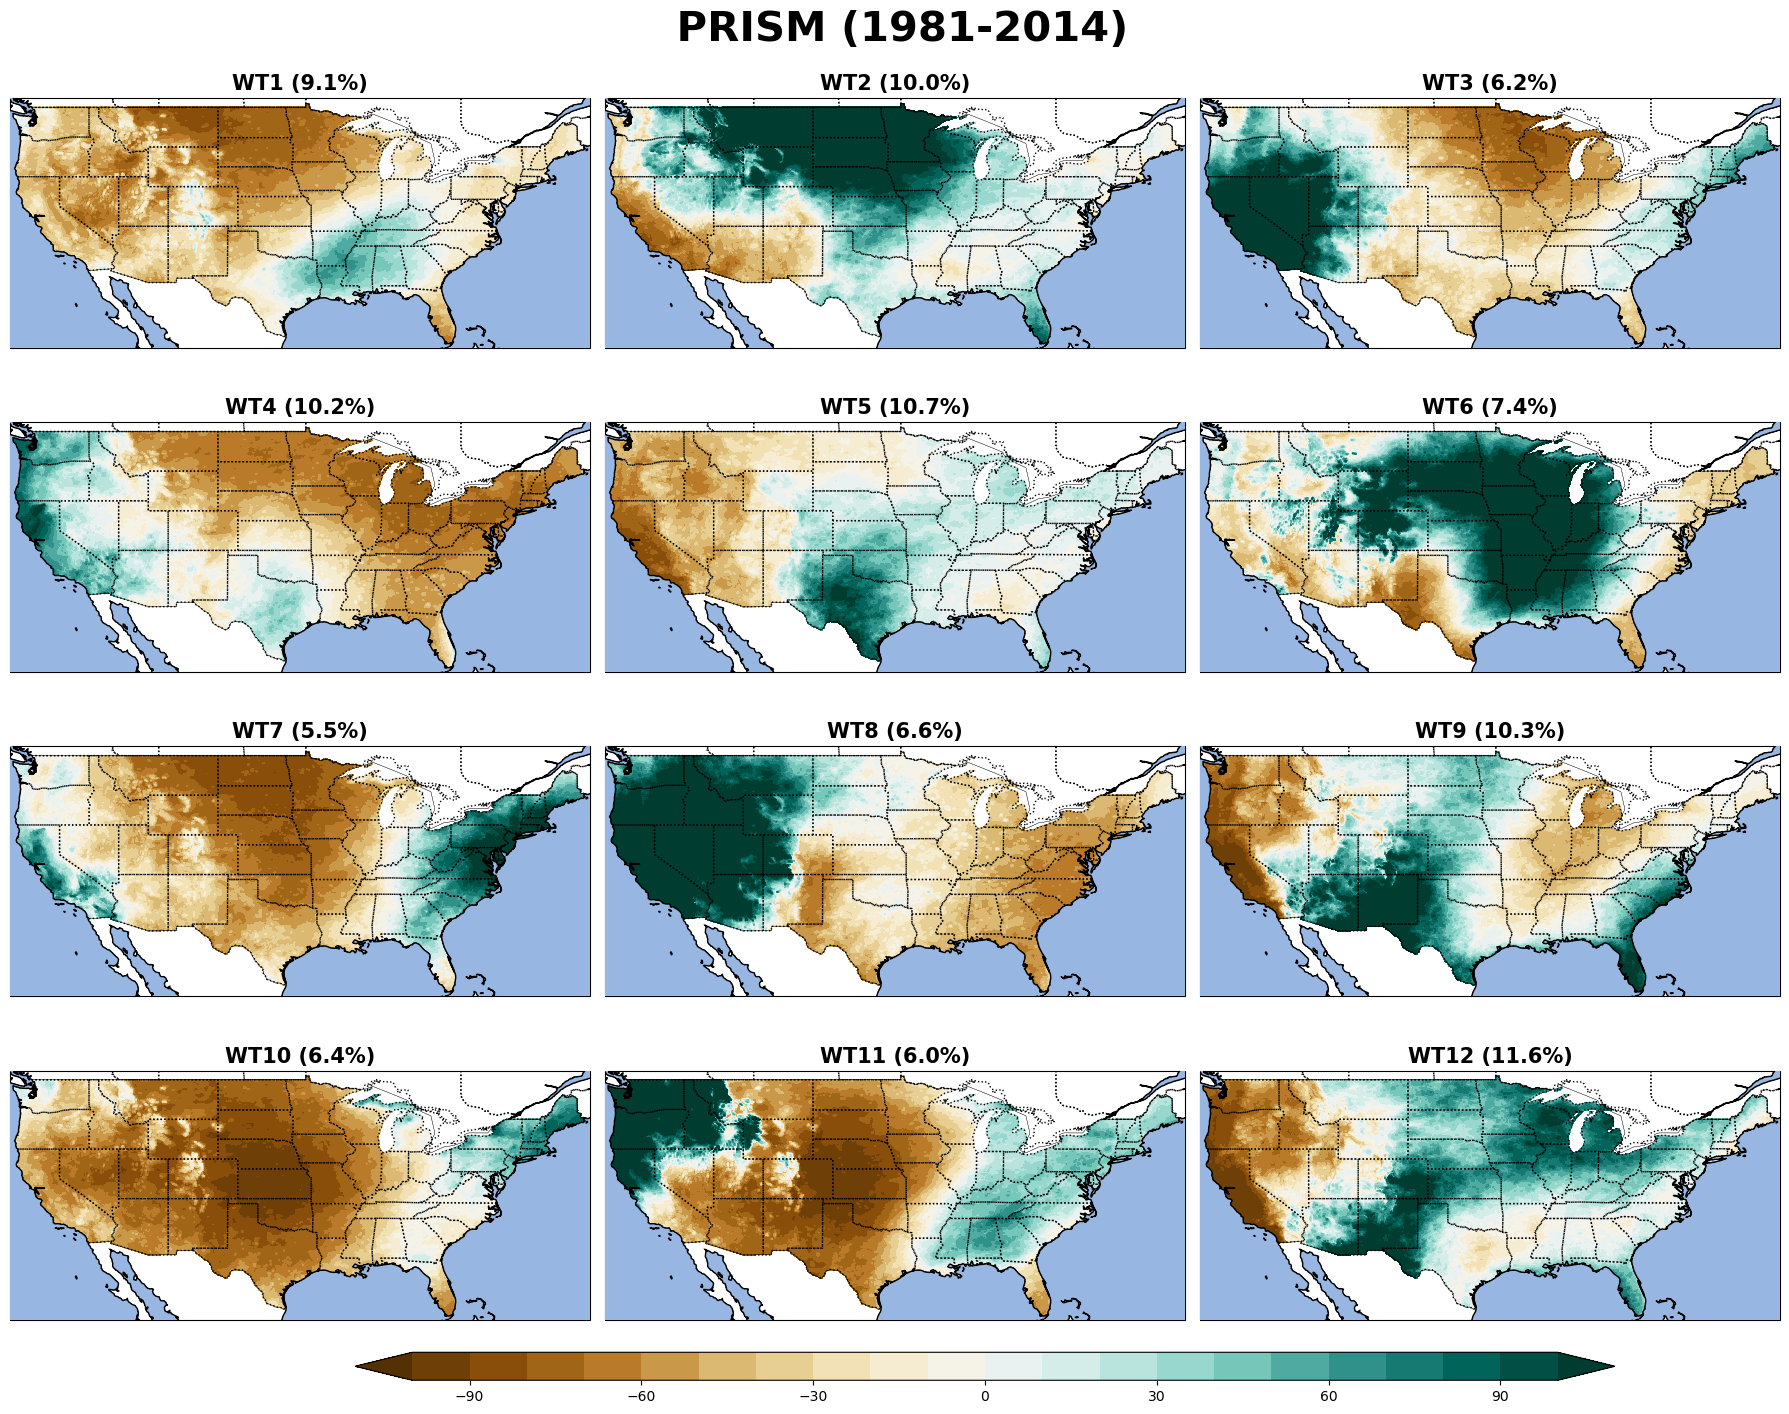

In [9]:
prec_avg = (prec_xr - prec_mean)/prec_mean*100
plot_prec_12_prism(prec_avg, -100, 100, 21, 'BrBG', nwt_1d, 'PRISM (1981-2014)') 

 - 1.3) Summer/Winter WT plot (12,9,2,5) for Erin

In [10]:
def plot_prec_spec(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s, wt_n, nwt_1d):
    '''
    prec(n_wt, nlat, nlon): 3d variable to plot 
    min_v: minimum value
    max_v: maximum value
    n_lev: number of contour 
    cmap_s: color map 
    colorbar_ori: colorbar orientation 
    title_s: plot title
    wt_n: weather type 
    '''
    import numpy as np
    proj = ccrs.PlateCarree()
     
    n_plot = len(wt_n)
    n_row = 4
    n_col = int(n_plot/n_row)
     
    if n_col == 1:
        fig = plt.figure(figsize=(6,14))
    elif n_col == 2:
        fig = plt.figure(figsize=(12,14))
        
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
    
    for np in range(n_plot):
        ax_s = plt.subplot(4, n_col, np+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')

        np_p1 = np + 1

        im = prec[wt_n[np]-1].plot.contourf(
                levels=cnlevel,
                cmap=cmap_s,
                ax=ax_s,
                center = 0,
                transform=ccrs.PlateCarree(),
                add_colorbar=False)

        
        ax_s.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
        #plt.title('WT' + str(wt_n[np]).zfill(2) + ' (' + str(f'{nwt_1d[wt_n[np]-1]:.1f}') + '%)',fontweight="bold", size=15)
   
        plt.title('WT' + str(wt_n[np]).zfill(2),fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle(' ' + title_s, fontweight="bold", fontsize=30)

    fig.tight_layout()

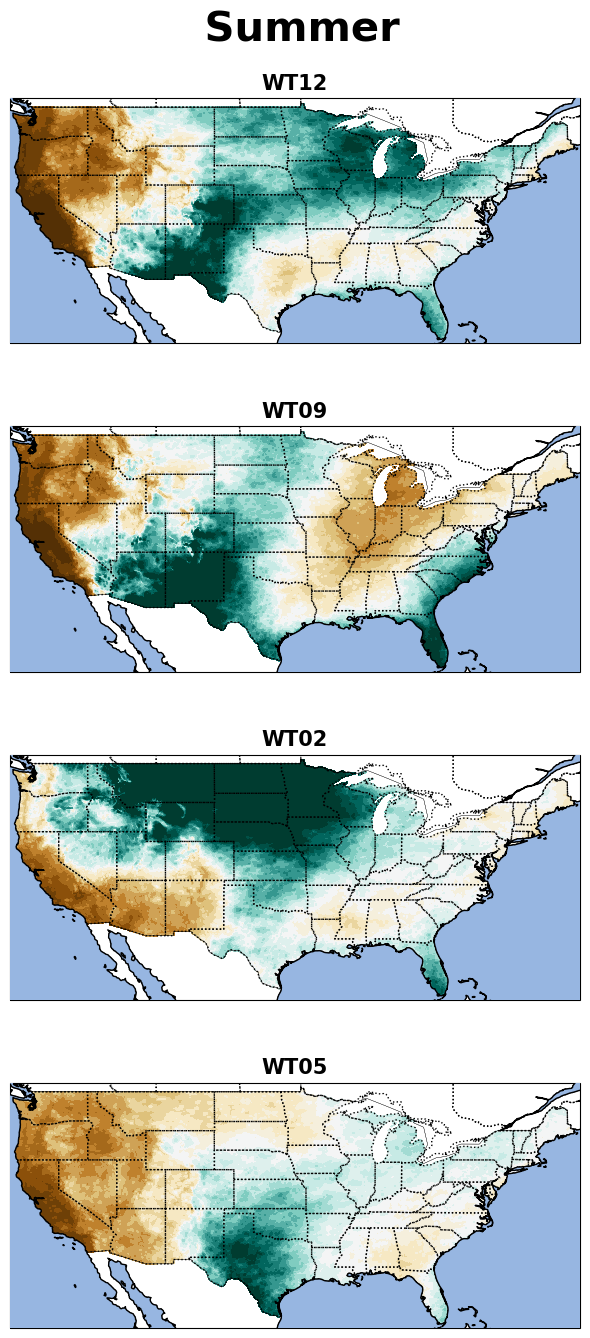

In [11]:
wt_n = [12,9,2,5]
#wt_n = [5,2,12,9]

prec_new = (prec_xr - prec_mean)/prec_mean*100
plot_prec_spec(prec_new, -100, 100, 21, 'BrBG', 'horizontal', 'Summer', wt_n, nwt_1d) 

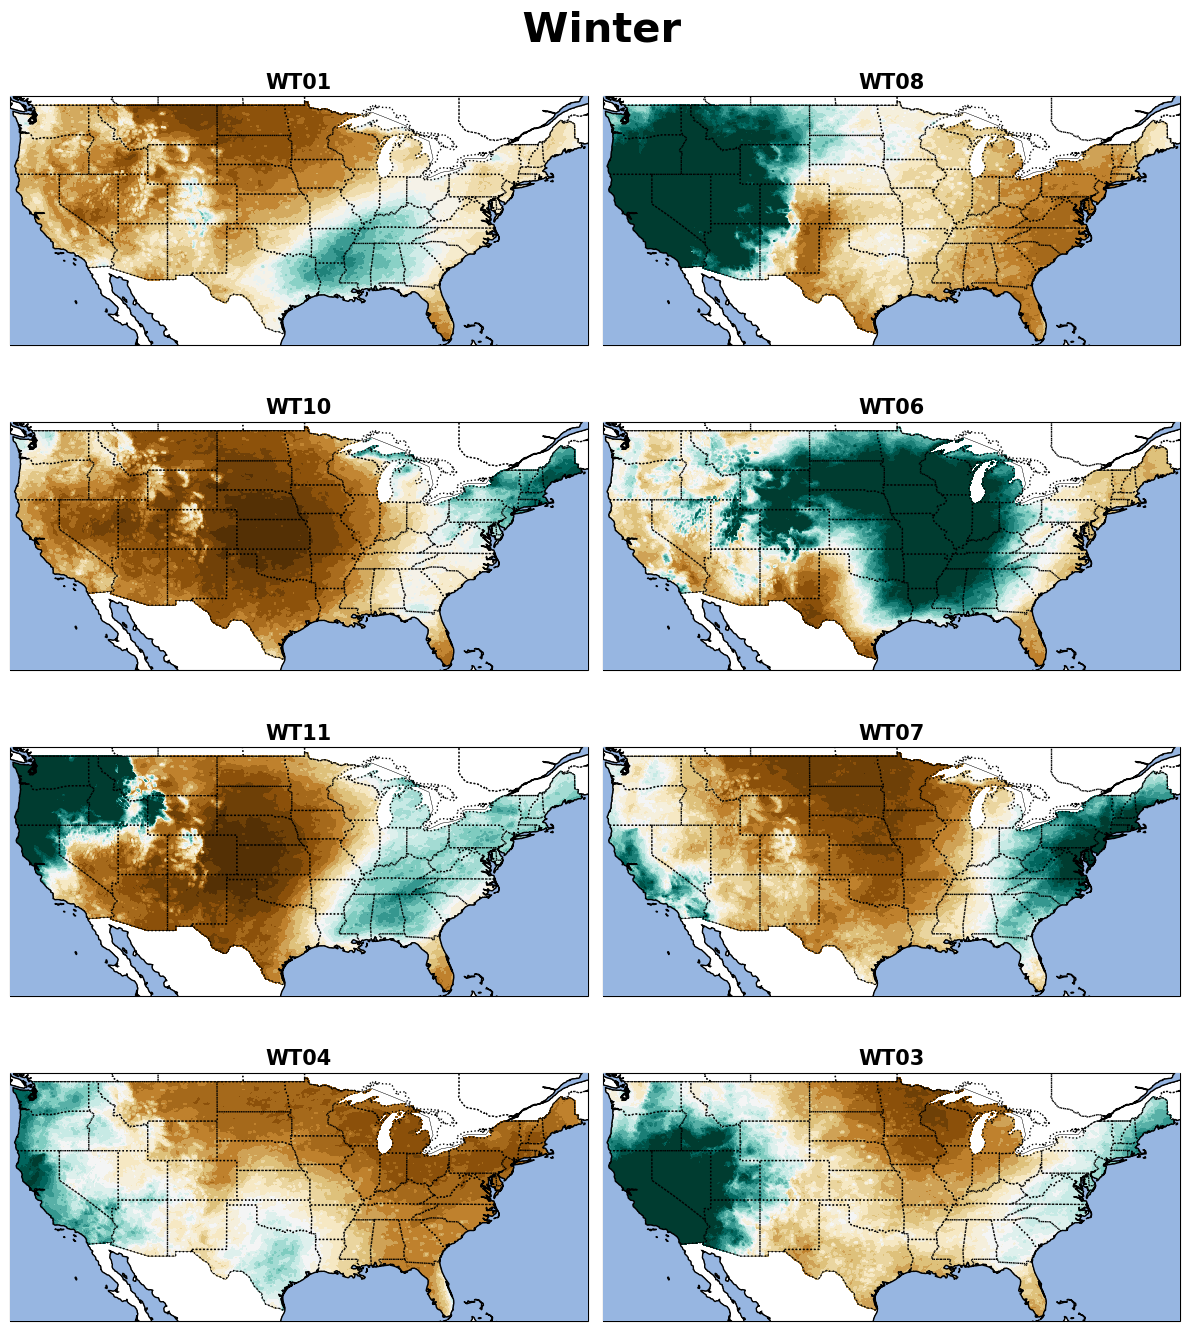

In [12]:
wt_n = [1,8,10,6,11,7,4,3]
plot_prec_spec(prec_new, -100, 100, 21, 'BrBG', 'horizontal', 'Winter', wt_n, nwt_1d) 

#### 2 Precipitation Seasonal anomaly
 - 2.1) seasonal climatology

In [9]:
flnm_cli = dir_o + 'prec_seasonal_cli.nc'
prec_cli_xr = cal_season_cli_prism('PR', dir_prism, season_dict, year_s, year_e, lat, lon, lat_s, lat_e, lon_s, lon_e, flnm_cli)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_seasonal_cli.nc exist
Frozen({'rlat': 605, 'rlon': 1405, 'season': 4})


 - 2.2) seasonal anomaly

In [10]:
flnm_cli = dir_o + 'prec_seasonal_cli.nc'
flnm_o = dir_o + 'prec_seasonal_ano.nc'
z500_wt = cal_season_ano_prism('PR', dir_prism, dir_wt, season_dict, year_s, year_e, lat_s, lat_e, lon_s, lon_e, flnm_cli, flnm_o)

/glade/campaign/mmm/c3we/mingge/COEXIST/PRISM/prec_seasonal_ano.nc exist


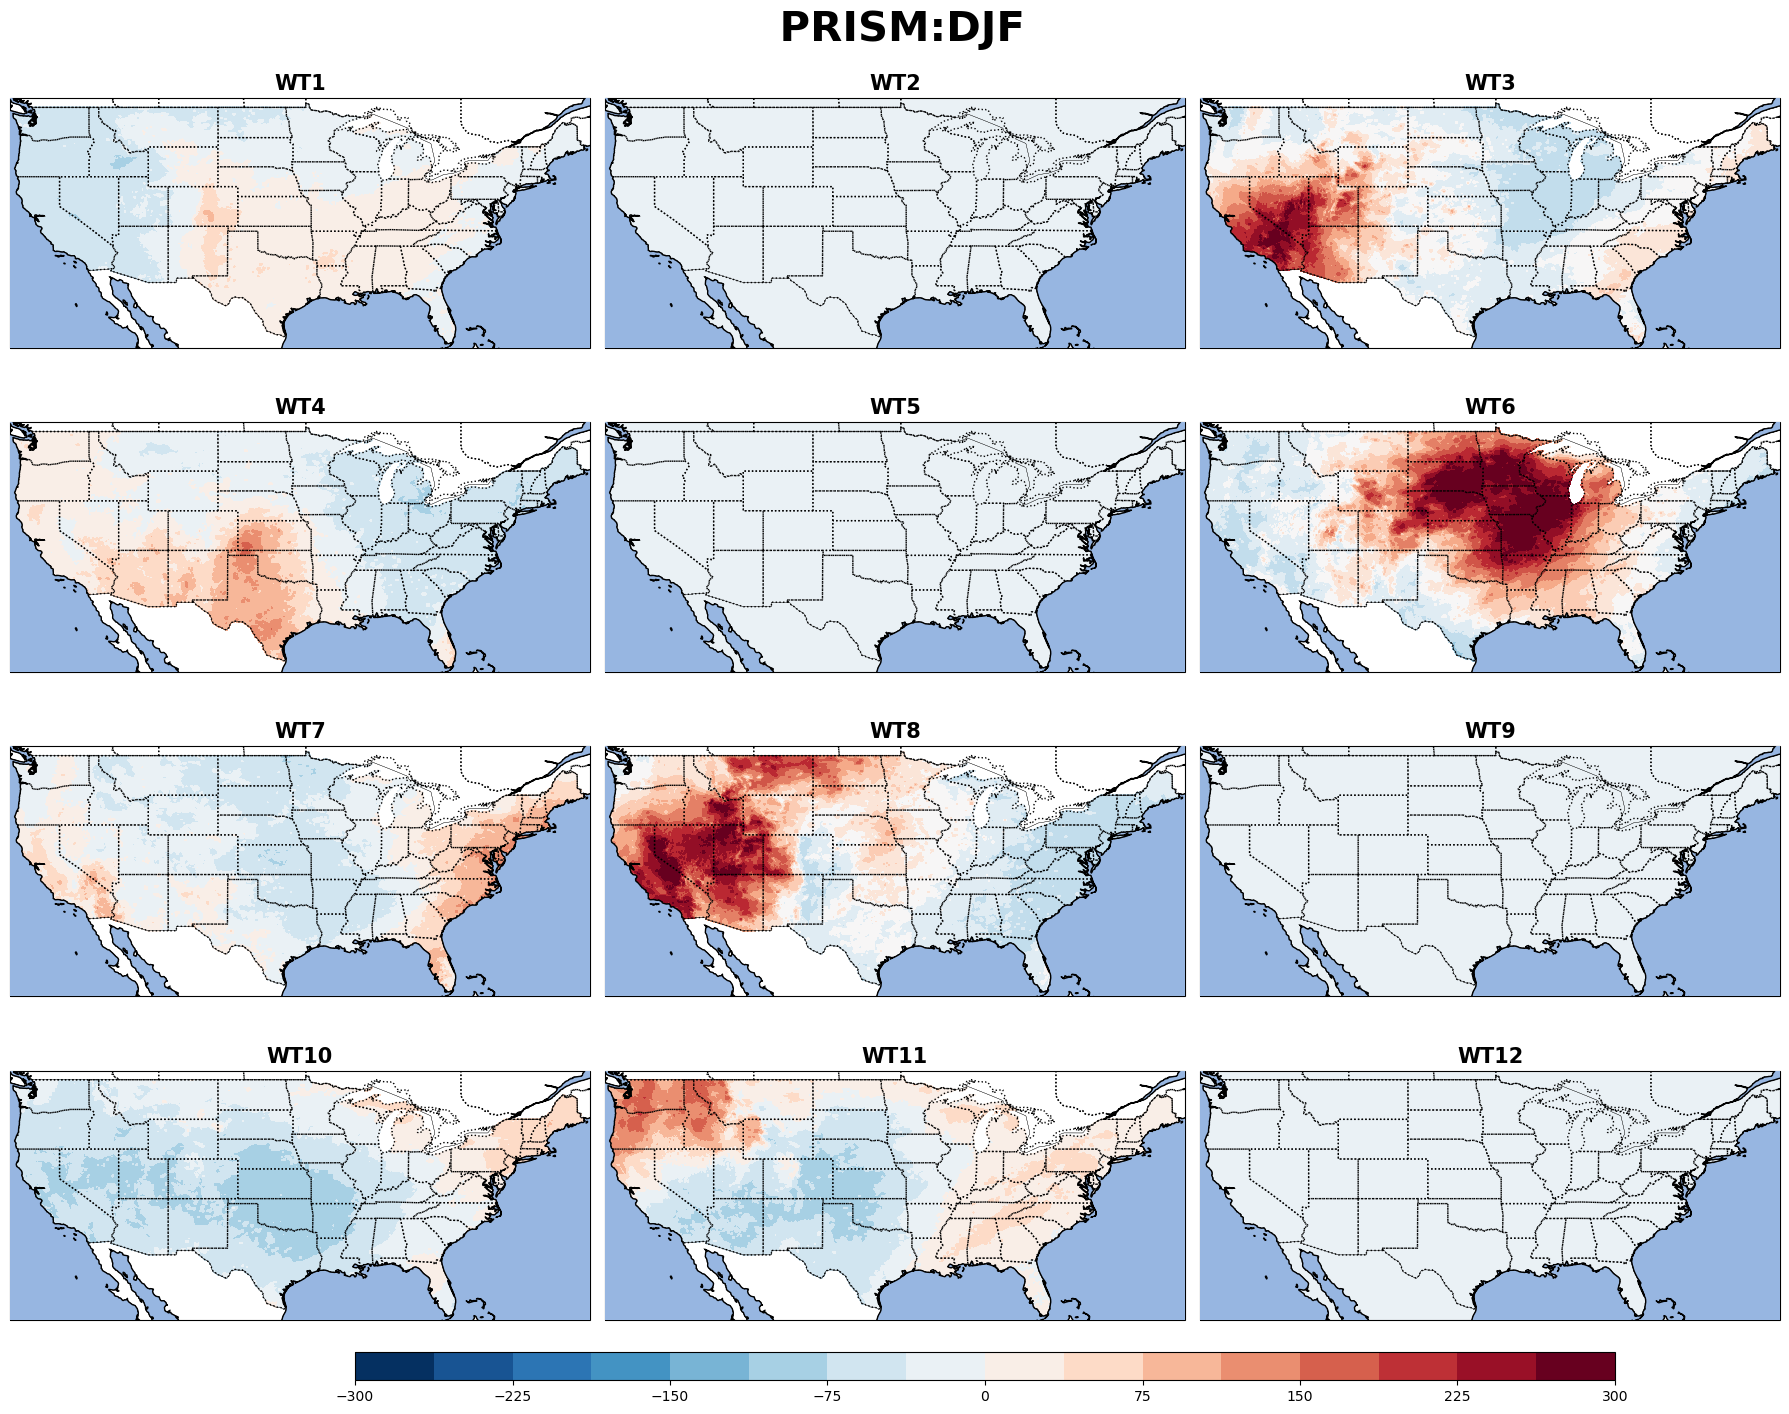

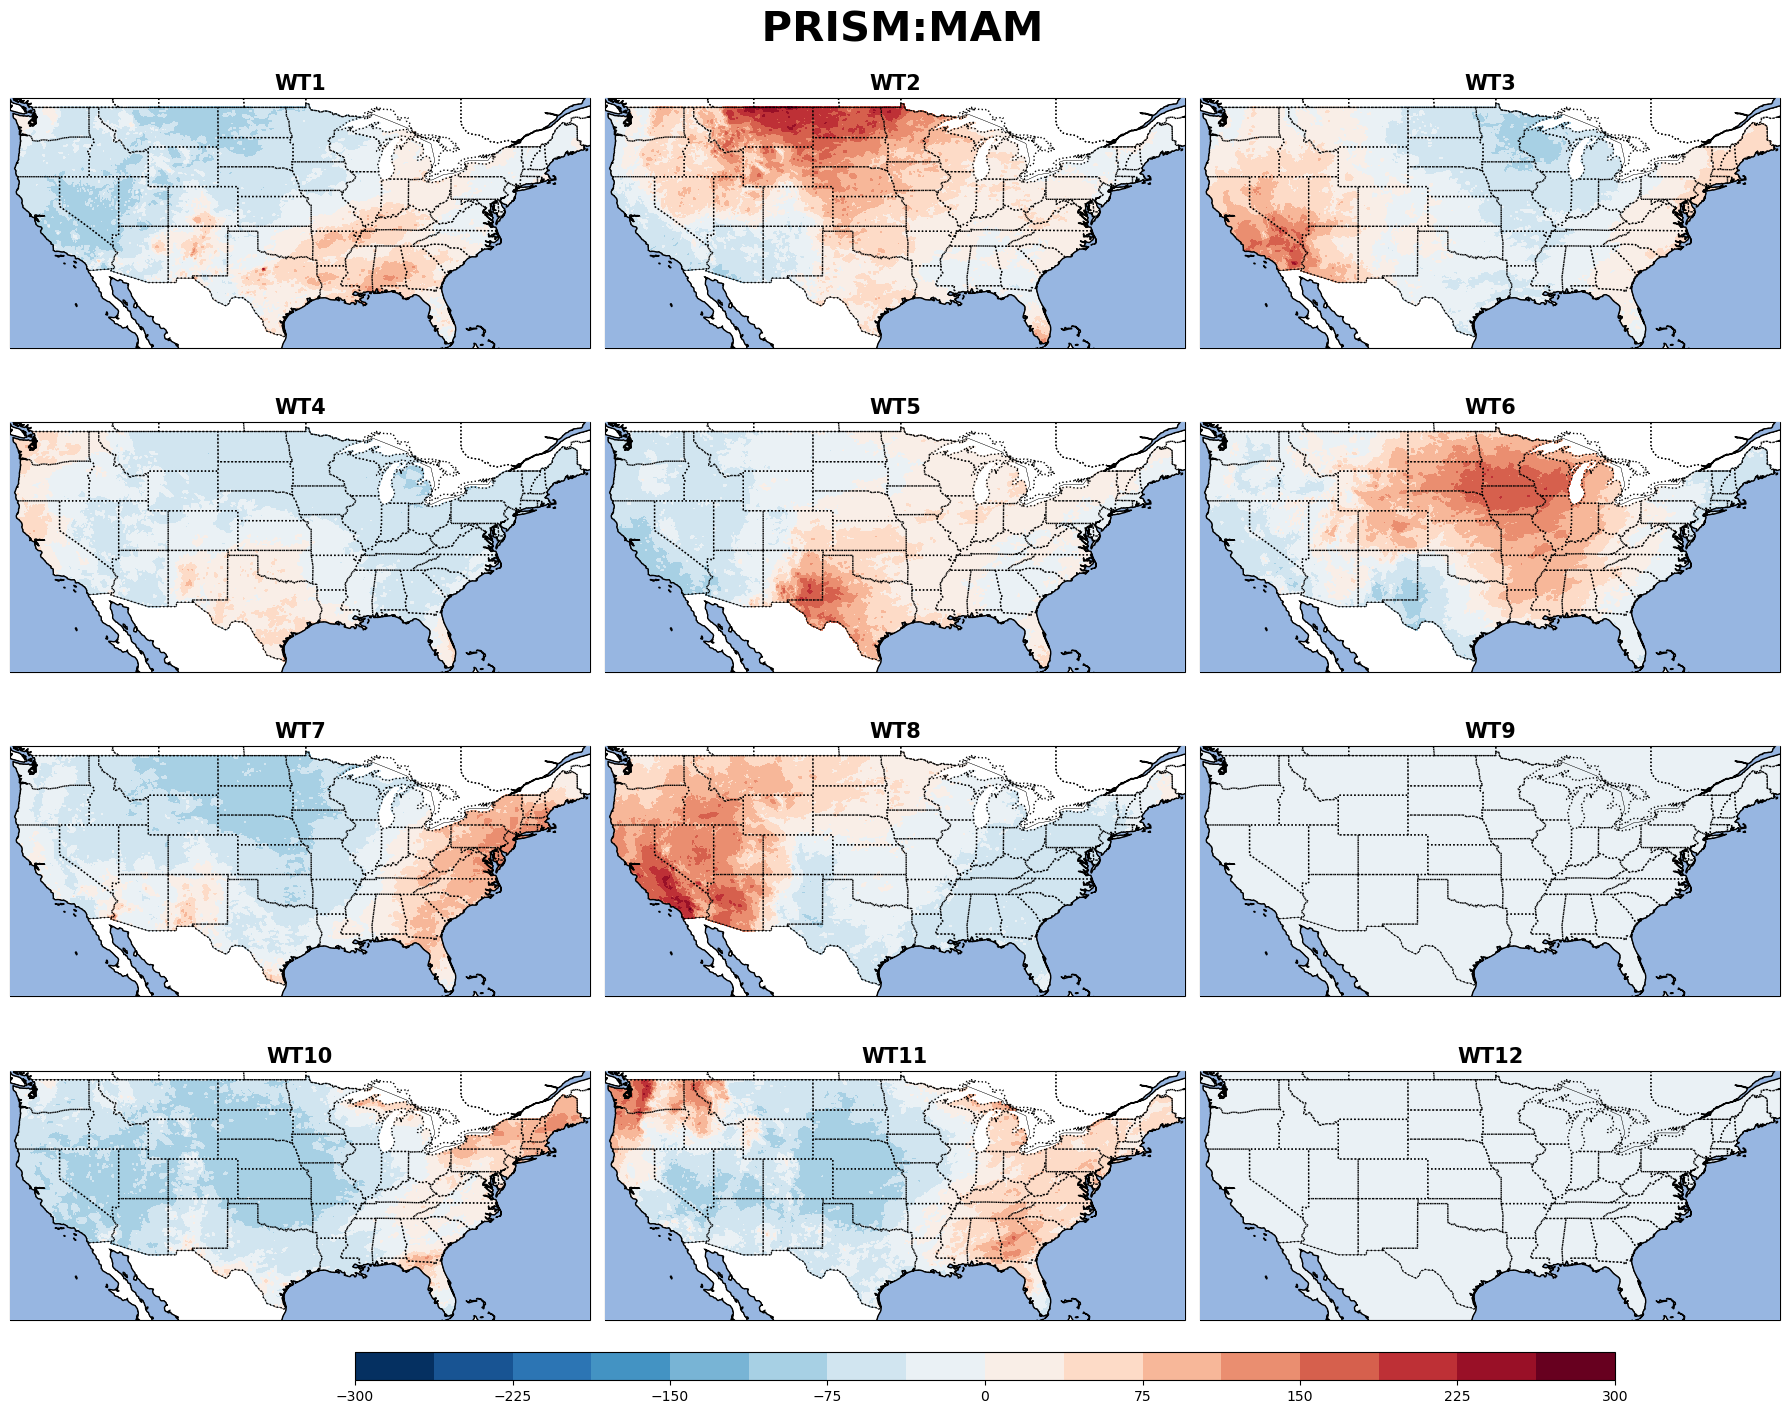

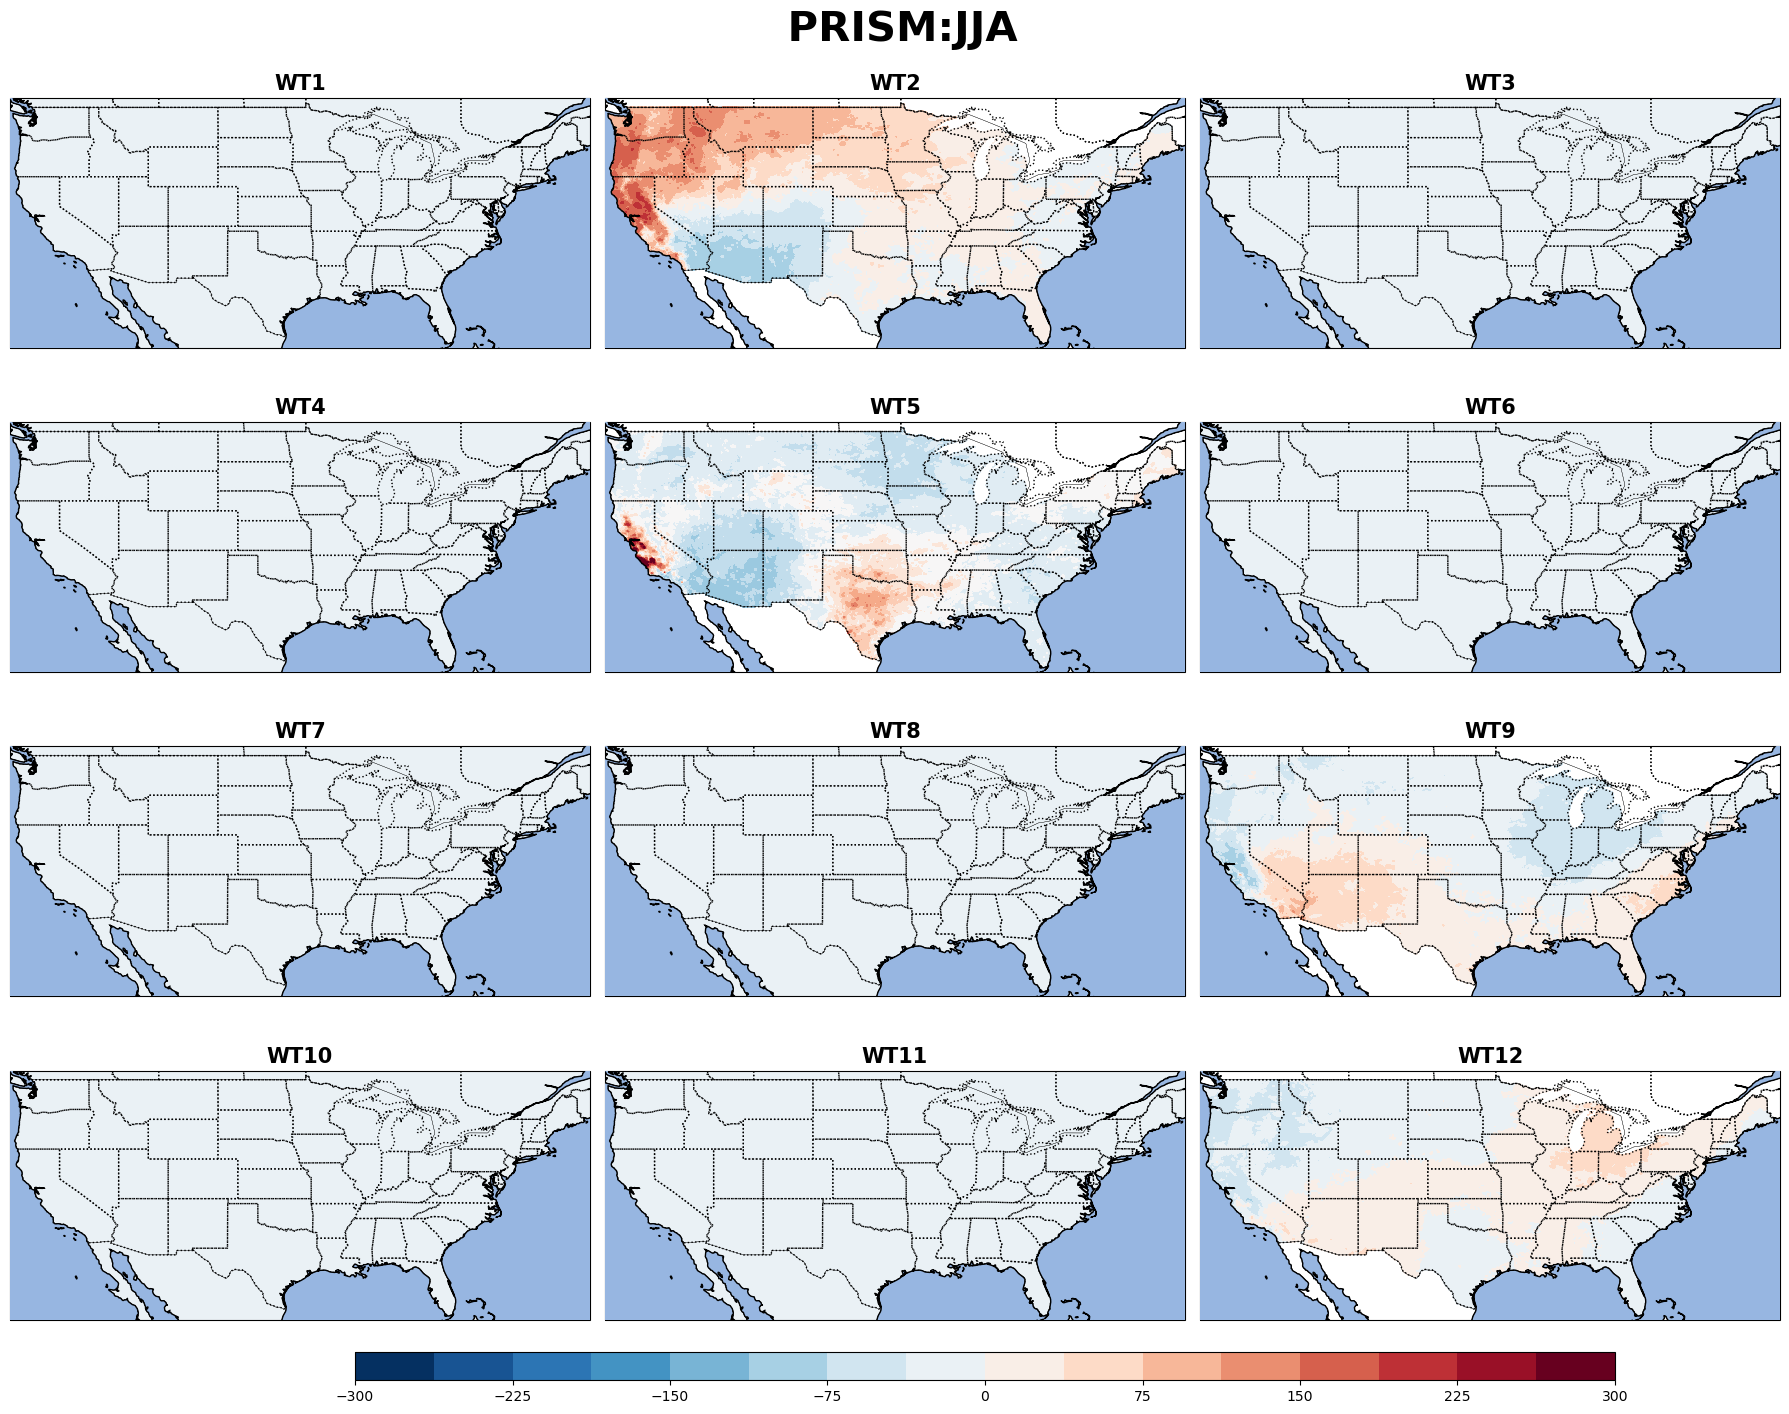

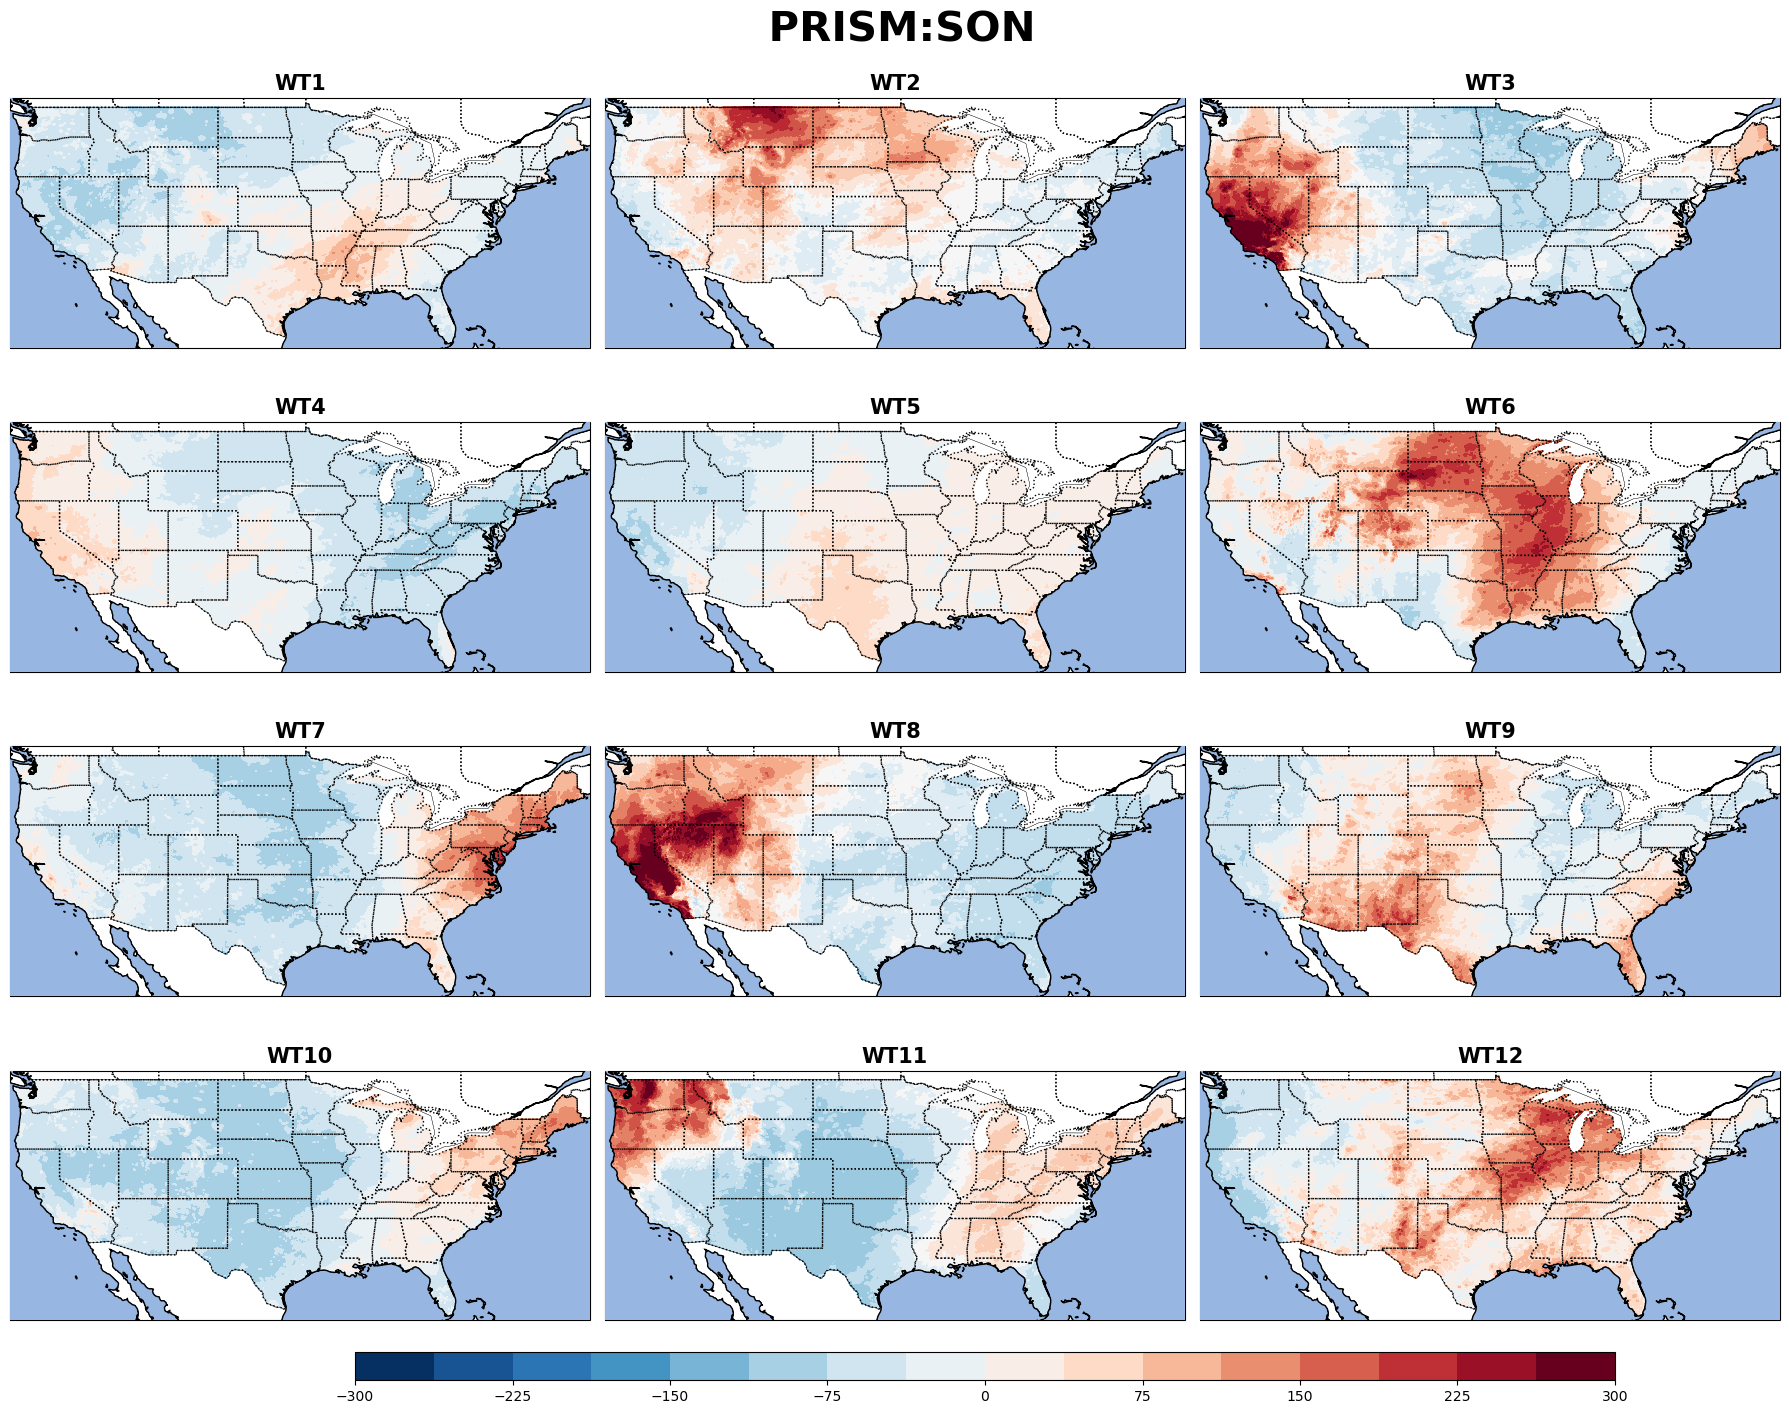

In [12]:
season_s = ['DJF','MAM','JJA','SON'] 
# plot 4 seasons
for ns in range(4):
    plot_prec_12(z500_wt[:,ns]*100, -300, 300, 17, 'RdBu_r', 'horizontal', 'PRISM:' + season_s[ns]);